# Found feature NN

A feed forward NN that only gets the input features that XGBoost finds to be important.

In [1]:
no_LUAD = True # should we leave the LUAD class out to see if the external performance dramatically improves?
cancer_type = '' # currently only works for cancer_type = ''
use_small = False
seed = 42
label = 'FeatureNN'
if no_LUAD:
    label = label + '_no_LUAD'

In [29]:
# get the data
import numpy as np
import pandas as pd
try:
    Xtrain_subset = pd.read_csv('TCGA-all-just-xgboost-features_train.csv', sep = '\t', index_col = 0)
    Xtrain_subset = Xtrain_subset.transpose()
    Xtrain_subset = np.array(Xtrain_subset)
    
    Xtest_subset = pd.read_csv('TCGA-all-just-xgboost-features_test.csv', sep = '\t', index_col = 0)
    Xtest_subset = Xtest_subset.transpose()
    Xtest_subset = np.array(Xtest_subset)

    ytrain = pd.read_csv('TCGA-all-diagnoses_train.csv', sep = '\t', index_col=0)
    ytest = pd.read_csv('TCGA-all-diagnoses_test.csv', sep = '\t', index_col=0)
    ytrain = np.array(ytrain)
    ytest = np.array(ytest)
    
except: # loading the data and extracting important features:
    # get the important features, found by xgboost
    features = pd.read_csv('../../xgboost/depth3est800lr189/feature_importances/_run_1.csv', header = None) # get features found by best performing multiclass xgboost
#     features = pd.read_csv('../../xgboost/feature_importances/' +cancer_type+ '_run_0.csv', header = None) # old xgboost features, this is how oldffNN was trained
    feature_nums = [int(features[0][i].split(' ')[2]) for i in range(len(features[0]))]
    len(feature_nums)
    
    # load whole input data and pick out probes in feature_nums

    import sys
    import os

    cwd = os.getcwd() # get the current path, and only take up to methylation-patterns-izzy (discarding the end bit)
    file = 'methylation-patterns-izzy'
    end = cwd.find(file) + len(file) + 1 # find start of file in path, add on its lenth to go to the end, and add on 1 to get the /
    path = cwd[0:end]
    print("path is ", path)
    sys.path.append(path)

    from get_train_and_test import get_train_and_test
    Xtrain, Xtest, ytrain, ytest = get_train_and_test(cancer_type, use_small, remove_inf = True, use_beta = False, root_path=path, model_type = cancer_type + label, seed = seed)
    
    Xtrain_subset = Xtrain[:, feature_nums]
    Xtest_subset = Xtest[:, feature_nums]
    
    # testing:
    Xtrain_subset.shape
    Xtest_subset.shape

    Xtrain[:, 3] # should be equal
    Xtrain_subset[:, 2]

    Xtest[:, 3]
    Xtest_subset[:, 2]
    
    # keras needs targets in one hot format:
    from keras.utils import to_categorical
    ytrain = to_categorical(ytrain)
    ytest = to_categorical(ytest)

In [30]:
# removing the LUAD class: (LUAD is number 9 in diagnoses)
if no_LUAD:
    LUAD_indices = np.argmax(ytrain, axis = 1) == 9
    sum(LUAD_indices)
    sum(np.logical_not(LUAD_indices))
    Xtrain_subset = Xtrain_subset[np.logical_not(LUAD_indices), ]
    ytrain = ytrain[np.logical_not(LUAD_indices)]
    
    LUAD_indices_test = np.argmax(ytest, axis = 1) == 9
    sum(LUAD_indices_test)
    sum(np.logical_not(LUAD_indices_test))
    Xtest_subset = Xtest_subset[np.logical_not(LUAD_indices_test), ]
    ytest = ytest[np.logical_not(LUAD_indices_test)]
    
    sum(np.argmax(ytrain, axis = 1) == 9) # should both be 0
    sum(np.argmax(ytest, axis = 1) == 9)
    
    # now deleting the LUAD axis so the diagnoses has 13 columns, not 14
    sum(ytrain[:, 9])
    ytrain = np.delete(ytrain, 9, axis = 1)
    ytest = np.delete(ytest, 9, axis = 1)

356

4312

119

1437

In [55]:
# checks:
Xtrain_subset.shape
Xtest_subset.shape
ytrain.shape
ytest.shape

(4312, 3388)

(1437, 3388)

(4312, 13)

(1437, 13)

In [56]:
# print(ytrain)
import numpy as np
num_classes = len(np.unique(ytest, axis=0))
print("num classes is ", num_classes)

num classes is  13


In [57]:
##### model parameters
# chosen in FoundFeatureNN_Hyperparam_search.ipynb

D_in=Xtrain_subset.shape[1] # input dimension (number of features)
num_epochs = 500
num_hiddens = [D_in, 256, 256, 128]
order_reg_layers = 'BN_dropout' # can be 'BN_dropout', 'dropout_BN', 'dropout', or 'BN'. The order of the regularisation layers
input_dropout = True # whether to have dropout before first layer
batch_size = 20
lr = 0.001
import keras
l_reg = None # regularizers.l1(0.01) # can be regularizers.l1(x) or regularizers.l2(x), or None
# applied to the weights of the network
# l1 regularisation on the weights results in sparse weights (this might be called weight decay?) (but might be less efficient than l2), l2 results in lower weights (but not sparse)


In [58]:
# make model

# get rid of old stored models
import tensorflow as tf
tf.keras.backend.clear_session()

# make model

# get rid of old stored models
import tensorflow as tf
tf.keras.backend.clear_session()

from keras.models import Sequential
model = Sequential()

from keras.layers import Dense, Dropout, BatchNormalization

if input_dropout == True:
    model.add(Dropout(rate = 0.2)) # the dropout paper suggests a 0.8 keep rate (0.2 dropout) for the input
for layer in range(1, len(num_hiddens)):
    model.add(Dense(units=num_hiddens[layer], activation='relu', input_dim=num_hiddens[layer-1], kernel_regularizer = l_reg))
    
    if order_reg_layers == 'BN_dropout':
        model.add(BatchNormalization())
        model.add(Dropout(rate = 0.5)) # the dropout paper suggests a rate of 0.5
    elif order_reg_layers == 'dropout_BN':
        model.add(Dropout(rate = 0.5)) # the dropout paper suggests a rate of 0.5
        model.add(BatchNormalization())
    elif order_reg_layers == 'dropout':
        model.add(Dropout(rate = 0.5)) # the dropout paper suggests a rate of 0.5
    elif order_reg_layers == 'BN':
        model.add(BatchNormalization())
    else:
        print("don't know that order_reg_layers, ", order_reg_layers)
    
model.add(Dense(units=num_classes, activation='softmax')) # last layer

# think BN goes before activtion, BUT some say its better after activtion - try both. Try BN after dropout? And some say its not good to also have dropout
# see https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout
# hyperparameter tuning resulted in BN and then dropout

In [59]:
# train

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr),
              metrics=['categorical_accuracy'])

# this saves the best model so far:
if no_LUAD:
    save_best_models = keras.callbacks.callbacks.ModelCheckpoint('FeatureNN_no_LUAD_'+cancer_type + '_best_model', monitor='val_categorical_accuracy', verbose=1, save_best_only=True)
else:
    save_best_models = keras.callbacks.callbacks.ModelCheckpoint('FeatureNN_'+cancer_type + '_best_model', monitor='val_categorical_accuracy', verbose=1, save_best_only=True)
history = model.fit(Xtrain_subset, ytrain, epochs=num_epochs, batch_size=batch_size, validation_split = 0.2, callbacks = [save_best_models])

print(model.summary())

# load best model found
from keras.models import load_model
if no_LUAD:
    model = load_model('FeatureNN_no_LUAD_'+cancer_type + '_best_model')
else:
    model = load_model('FeatureNN_'+cancer_type + '_best_model')

label = 'FeatureNN_'+cancer_type
if use_small:
    label = label+'small'
if no_LUAD:
    label = label + '_no_LUAD'
model.save(label + '_model.h5')


losses = history.history["loss"]
val_loss = history.history["val_loss"]

import matplotlib.pyplot as plt
plt.clf()
plt.plot(losses)
plt.plot(val_loss)
plt.legend(["train loss", "val loss"])

if no_LUAD:
    label = 'figs_no_LUAD/loss_curve_FeatureNN_no_LUAD_'+cancer_type
else:
    label = 'figs/loss_curve_FeatureNN_'+cancer_type
if use_small:
    label = label + 'small'

plt.savefig(label)
plt.show()



Train on 3449 samples, validate on 863 samples
Epoch 1/500
3449/3449 [==============================] - 3s 824us/step - loss: 1.2993 - categorical_accuracy: 0.6138 - val_loss: 0.3890 - val_categorical_accuracy: 0.8830

Epoch 00001: val_categorical_accuracy improved from -inf to 0.88297, saving model to FeatureNN_no_LUAD__best_model
Epoch 2/500
3449/3449 [==============================] - 2s 644us/step - loss: 0.5686 - categorical_accuracy: 0.8263 - val_loss: 0.1830 - val_categorical_accuracy: 0.9571

Epoch 00002: val_categorical_accuracy improved from 0.88297 to 0.95713, saving model to FeatureNN_no_LUAD__best_model
Epoch 3/500
3449/3449 [==============================] - 2s 649us/step - loss: 0.4289 - categorical_accuracy: 0.8727 - val_loss: 0.1517 - val_categorical_accuracy: 0.9490

Epoch 00003: val_categorical_accuracy did not improve from 0.95713
Epoch 4/500
3449/3449 [==============================] - 2s 704us/step - loss: 0.3297 - categorical_accuracy: 0.9066 - val_loss: 0.1274 

<Figure size 640x480 with 1 Axes>

Acc, conf mat:
0.9798190675017397
[[164   0   0   0   1   2   0   0   0   0   7   1   0]
 [  0 103   0   1   0   0   0   0   0   0   0   0   0]
 [  2   0 195   0   0   0   1   0   0   0   0   0   0]
 [  0   0   0  79   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  45   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0 132   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  79   2   0   0   0   0   0]
 [  0   1   0   0   0   0   1  67   0   0   0   0   0]
 [  2   0   0   0   0   0   0   0  93   0   0   0   0]
 [  1   0   0   0   1   1   0   0   0  90   0   0   0]
 [  4   0   0   0   0   0   0   0   0   0 122   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 129   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 110]]
precision, recall, f1 for each class:
[0.94797688 0.99038462 1.         0.9875     0.95744681 0.97058824
 0.97530864 0.97101449 1.         1.         0.94573643 0.99230769
 1.        ] [0.93714286 0.99038462 0.98484848 1.         0.97826087 1.
 0.975

array([11, 10,  4, ...,  0,  6, 11])

       Normal  BLCA  BRCA  COAD  ESCA  HNSC  KIRC  KIRP  LIHC  LUSC  PRAD  \
0.0  0.000000   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
0.0  0.005714   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
0.0  0.011429   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
0.0  0.022857   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
0.0  0.045714   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
..        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
0.0       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
0.0       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
0.0       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
0.0       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1.0       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

     THCA      UCEC  
0.0   NaN       NaN  
0.0   NaN       NaN  
0.0   NaN

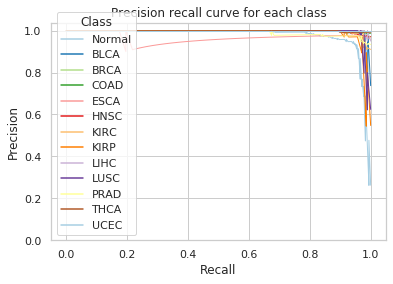

In [66]:
# evaluate
import sys
sys.path.append('/Tank/methylation-patterns-code/methylation-patterns-izzy/')
y_pred = model.predict(Xtest_subset, batch_size=Xtest_subset.shape[0])
import numpy as np

import Evaluate
label = 'FeatureNN_'+cancer_type
if use_small:
    label = label+'small'
if no_LUAD:
    label = label + '_no_LUAD'

from Evaluate import print_evaluation, plot_curve
if no_LUAD:
    print_evaluation(None, None, np.argmax(ytest, axis=1), label, predictions=np.argmax(y_pred, axis=1), prob_predictions=y_pred, small_text = True, save_folder = 'figs_no_LUAD/') # fitted and m_values are none because we are providing predictions
else:
    print_evaluation(None, None, np.argmax(ytest, axis=1), label, predictions=np.argmax(y_pred, axis=1), prob_predictions=y_pred, small_text = True) # fitted and m_values are none because we are providing predictions

import numpy as np
num_classes = len(np.unique(ytest, axis=0))
plot_curve('roc', np.argmax(ytest, axis=1), y_pred, num_classes, label, save_folder = 'figs_no_LUAD/')
plot_curve('precision_recall', np.argmax(ytest, axis=1), y_pred, num_classes, label, save_folder = 'figs_no_LUAD/')



In [4]:
# saving to file, so don't have to Xtest_subsetle dataset again
def save_to_file():
    values = pd.read_csv('../../data_preprocessing/dataset/pandas/m_values/TCGA-all.csv', sep='\t', usecols=[0])
    # values

    probes = values['probe'][feature_nums]

    # Xtrain_subset
    dm = pd.DataFrame(Xtrain[:, feature_nums].transpose(), index = probes)
    dm.to_csv('TCGA-all-just-xgboost-features_train.csv', sep='\t')

    # Xtest
    dm = pd.DataFrame(Xtest[:, feature_nums].transpose(), index = probes)
    dm.to_csv('TCGA-all-just-xgboost-features_test.csv', sep='\t')

    # diagnoses
    dd = pd.DataFrame(ytrain)
    dd.to_csv('TCGA-all-diagnoses_train.csv', sep='\t')
    dd = pd.DataFrame(ytest)
    dd.to_csv('TCGA-all-diagnoses_test.csv', sep='\t')

save_to_file()

In [65]:
import importlib
import Evaluate
importlib.reload(Evaluate)

<module 'Evaluate' from '/Tank/methylation-patterns-code/methylation-patterns-izzy/Evaluate.py'>